In [1]:
import galsim
import numpy as np
import proplot as plot

In [23]:
from numba import njit

@njit
def _meas_cf(im):
    nx = im.shape[1]
    ny = im.shape[0]
    cov = np.zeros((3, 3))
    n = 0
    for x in range(1, nx-2):
        for y in range(1, ny-2):
            for i in range(3):
                for j in range(3):
                    cov[j, i] += im[y+j-1, x+i-1] * im[y, x]

            n += 1
    cov = cov/n
    return cov

def meas_cf(im):
    cov = _meas_cf(im)
    covr = np.rot90(np.rot90(cov))
    return (cov + covr)/2

In [ ]:
dim = 200

nse = galsim.UncorrelatedNoise(1)
nse_p = galsim.UncorrelatedNoise(1).shear(g1=0.9, g2=0)
nse_m = galsim.UncorrelatedNoise(1).shear(g1=-0.9, g2=0)
im_pm = galsim.ImageD(dim, dim)
nse_p.applyTo(im_pm)
nse_m.applyTo(im_pm)

im_w = galsim.ImageD(dim, dim)
nse_p.applyTo(im_w)
nse_p.whitenImage(im_w)

im_sp = galsim.ImageD(dim, dim)
nse_p.applyTo(im_sp)
nse_p.symmetrizeImage(im_sp)

im_sm = galsim.ImageD(dim, dim)
nse_m.applyTo(im_sm)
nse_m.symmetrizeImage(im_sm)

im_nc = galsim.ImageD(dim, dim)
nse.applyTo(im_nc)

fig, axs = plot.subplots()
axs[0].imshow(im_w.array, cmap='rocket')

In [ ]:
print(
    "pm:\n", meas_cf(im_pm.array), 
    "\nw:\n", meas_cf(im_w.array), 
    "\nnc:\n", meas_cf(im_nc.array),
    "\nsp:\n", meas_cf(im_sp.array),
    "\nsm:\n", meas_cf(im_sm.array),
)

In [3]:
def make_nse_pair(g1, g2):
    dim = 701
    ddim = int(dim - 2*np.sqrt(g1**2 + g2**2)*dim)
    if ddim % 2 == 0:
        ddim -= 1
    
    ns = galsim.InterpolatedImage(
        galsim.ImageD(np.random.normal(size=(dim, dim), scale=1)), 
        scale=1,
    )
    print(np.std(ns.drawImage(nx=ddim, ny=ddim, scale=1, method="no_pixel").array))
    nsp = ns.shear(g1=g1, g2=g2).drawImage(nx=ddim, ny=ddim, scale=1, method="no_pixel").array
    nsm = ns.shear(g1=-g1, g2=g2).drawImage(nx=ddim, ny=ddim, scale=1, method="no_pixel").array
    return nsp, nsm

1.001605
1.0009121


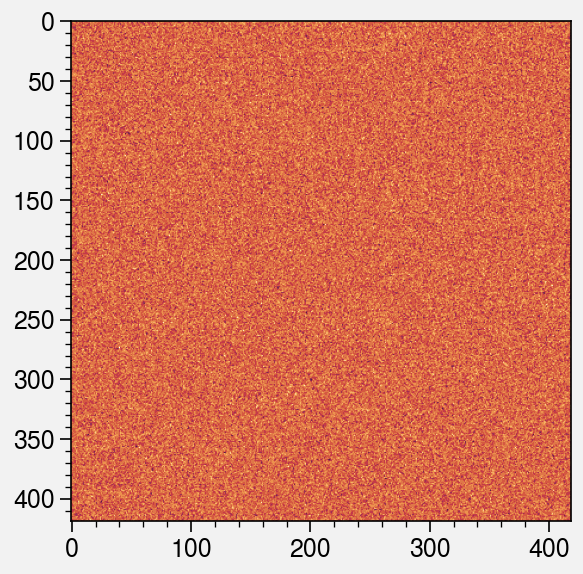

In [36]:
g1 = 0.2
nsp, nspm = make_nse_pair(g1, 0.0)
nsmp, nsm = make_nse_pair(g1, 0.0)

fig, axs = plot.subplots()
axs.imshow(nsp-nspm)
axs.grid(False)

In [43]:
meas_cf((nsp-nspm + (nsm-nsmp))/np.sqrt(2))
print(meas_cf(nsp), "\n", meas_cf(nsp+nsm))

[[-0.01215441 -0.03456058 -0.00897119]
 [ 0.22708402  0.77257831  0.22708402]
 [-0.00897119 -0.03456058 -0.01215441]] 
 [[-0.02395578  0.1946191  -0.0220397 ]
 [ 0.18510652  1.54379964  0.18510652]
 [-0.0220397   0.1946191  -0.02395578]]


In [51]:
cnp = galsim.CorrelatedNoise(galsim.ImageD(nsp.copy(), scale=1), scale=1, x_interpolant='lanczos15')
cnm = galsim.CorrelatedNoise(galsim.ImageD(nspm.copy(), scale=1), scale=1, x_interpolant='lanczos15')
# cnp = galsim.UncorrelatedNoise(1, scale=1).shear(g1=0.1, g2=0)
# cnm = galsim.UncorrelatedNoise(1, scale=1).shear(g1=-0.1, g2=0)

gnsp = galsim.ImageD(nsp.copy(), scale=1)
for _ in range(1):
    cnp = galsim.CorrelatedNoise(gnsp.copy(), scale=1)
    gnsp.symmetrizeNoise(cnp)
gnsp = gnsp.array

gnspm = galsim.ImageD(nspm.copy(), scale=1)
gnspm.symmetrizeNoise(cnm)
gnspm = gnspm.array

meas_cf(nsp), meas_cf(gnsp), meas_cf(nsm), meas_cf(gnspm)

(array([[-0.01215441, -0.03456058, -0.00897119],
        [ 0.22708402,  0.77257831,  0.22708402],
        [-0.00897119, -0.03456058, -0.01215441]]),
 array([[-0.05294316,  0.21919388, -0.06126016],
        [ 0.08882826,  1.48661781,  0.08882826],
        [-0.06126016,  0.21919388, -0.05294316]]),
 array([[-0.01360602,  0.22983793, -0.01135409],
        [-0.03913385,  0.77123836, -0.03913385],
        [-0.01135409,  0.22983793, -0.01360602]]),
 array([[-0.04257096,  0.09524726, -0.05447001],
        [ 0.218087  ,  1.48292329,  0.218087  ],
        [-0.05447001,  0.09524726, -0.04257096]]))

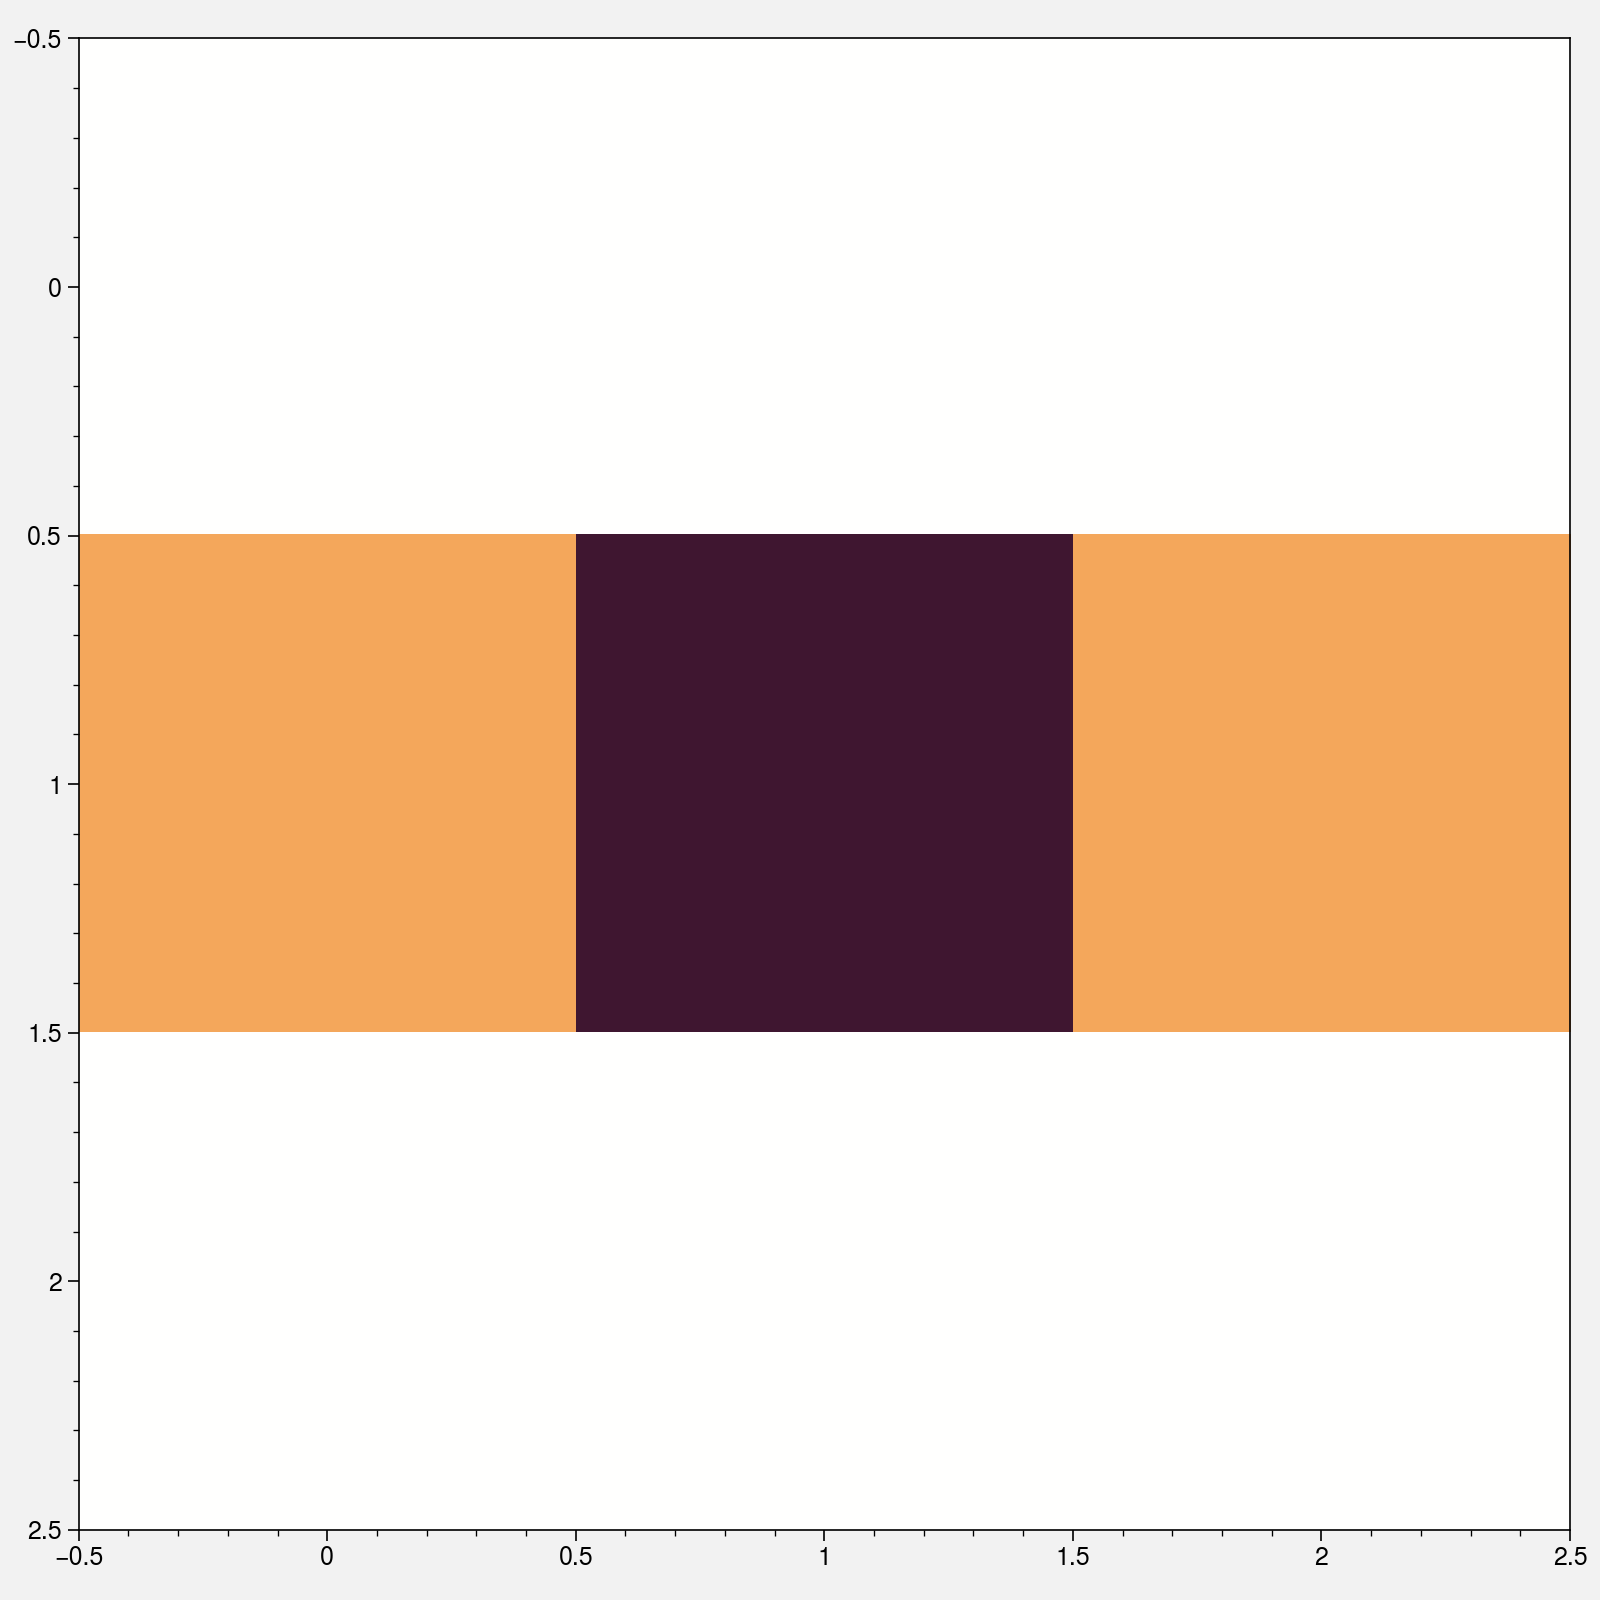

In [11]:
image = galsim.ImageD(3, 3, scale=1)
fig, axs = plot.subplots(figsize=(8, 8))
axs.imshow(cnp.drawImage(image=image).array)
axs.grid(False)

array([[-0.01264785, -0.03991386, -0.01096452],
       [ 0.22355316,  0.7692347 ,  0.22355316],
       [-0.01096452, -0.03991386, -0.01264785]])

In [31]:
cnp = galsim.CorrelatedNoise(galsim.ImageD(nsp.copy(), scale=1), scale=1)
print("gs:\n", cnp.drawImage(image=image).array, "\nme:\n", meas_cf(nsp))

gs:
 [[-0.01264785 -0.03991386 -0.01096452]
 [ 0.22355316  0.7692347   0.22355316]
 [-0.01096452 -0.03991386 -0.01264785]] 
me:
 [[-0.01276015 -0.03945781 -0.01058344]
 [ 0.22347653  0.76877756  0.22347653]
 [-0.01058344 -0.03945781 -0.01276015]]
